In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
assemblies = ['hg38', 't2t', 'afr']
c_dict, order = get_population_colors()
meta = load_meta()
meta.rename({'sample':'cell_line_id'}, axis=1, inplace=True)

## % reads that map to afr contigs by poputlation

In [35]:
def plot_thing(df, subset, thresh, how):
    """
    how = 'best' or 'any'
    """
    
    init_plot_settings(aspect='rectangle')
    temp = df.copy(deep=True)
    for key, value in subset.items():
        temp = temp.loc[temp[key]==value]
    # temp = df.loc[df.afr==True]
    # ax = sns.violinplot(temp, y='', hue='population', x='population', palette=c_dict, order=order) 
    # ax = sns.stripplot(temp, y='perc', x='', hue='population', palette=c_dict, order=order) 

    sns.violinplot(x='population', y='perc', data=temp, 
                   bw=0.2, order=order, inner=None, cut=0,
                   linewidth=1, scale='width', palette=c_dict)
    sns.stripplot(x='population', y='perc', data=temp,
                  jitter=True, order=order, palette=c_dict,
                  edgecolor='k', linewidth=0.5)


    ax = plt.gca()
    if how == 'any':
        title = f'% reads w/ MAPQ>={thresh} from each sample'
        ylabel = '% reads mapping to Afr. contigs'
    elif how == 'best':
        title = f'% of reads w/ MAPQ>={thresh} and BEST mapping from each sample'
        ylabel = '% reads mapping best to Afr. contigs'
    ax.set(title=title, ylabel=ylabel)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    plt.show()


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


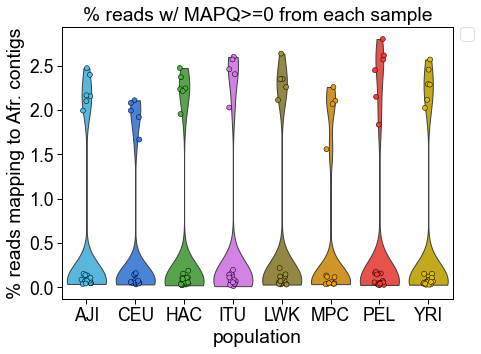

In [37]:
thresh = 0
f = expand(proc_cfg(config['lr']['map']['mapq_tsv_summary'], od),
           thresh=thresh)[0]
df = pd.read_csv(f, sep='\t')
df['cell_line_id'] = df.dataset.str.split('_', expand=True)[0]
df = df.merge(meta[['population', 'cell_line_id']],
              how='left', on='cell_line_id')
df.head()

plot_thing(df, {'afr':True}, thresh, how='any')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


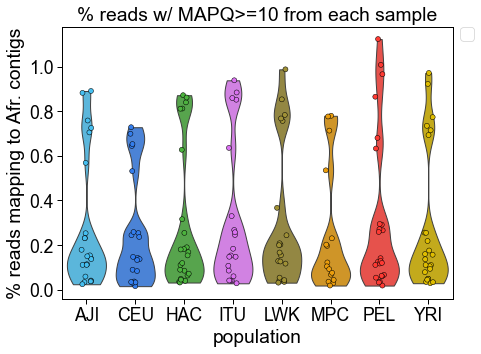

In [38]:
thresh = 10
f = expand(proc_cfg(config['lr']['map']['mapq_tsv_summary'], od),
           thresh=thresh)[0]
df = pd.read_csv(f, sep='\t')
df['cell_line_id'] = df.dataset.str.split('_', expand=True)[0]
df = df.merge(meta[['population', 'cell_line_id']],
              how='left', on='cell_line_id')
df.head()

plot_thing(df, {'afr':True}, thresh, how='any')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


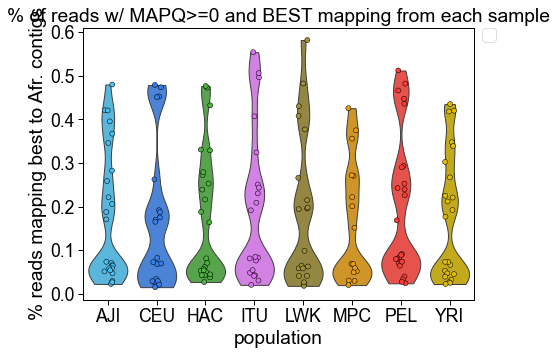

In [39]:
thresh = 0
f = expand(proc_cfg(config['lr']['map']['max_mapq_tsv_summary'], od),
           thresh=thresh)[0]
df = pd.read_csv(f, sep='\t')
df['cell_line_id'] = df.dataset.str.split('_', expand=True)[0]
df = df.merge(meta[['population', 'cell_line_id']],
              how='left', on='cell_line_id')
df.head()

plot_thing(df, {'afr':True}, thresh, how='best')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


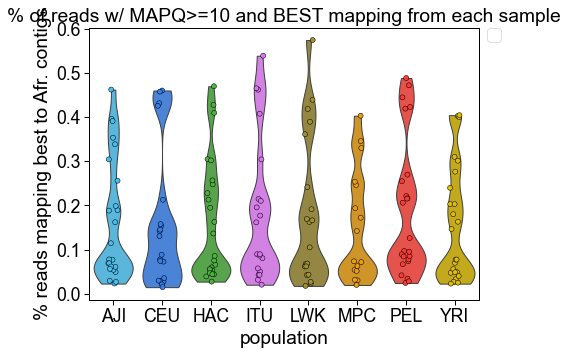

In [40]:
thresh = 10
f = expand(proc_cfg(config['lr']['map']['max_mapq_tsv_summary'], od),
           thresh=thresh)[0]
df = pd.read_csv(f, sep='\t')
df['cell_line_id'] = df.dataset.str.split('_', expand=True)[0]
df = df.merge(meta[['population', 'cell_line_id']],
              how='left', on='cell_line_id')
df.head()

plot_thing(df, {'afr':True}, thresh, how='best')

In [25]:
temp = df.copy(deep=True)
temp.set_index(assemblies, inplace=True)
temp.head()

,,,n_reads,total_reads,perc,sample,dataset,cell_line_id,population
hg38,t2t,afr,,,,,,,
False,False,False,72434,10570840,0.685225,GM19117_1,GM19117_1,GM19117,YRI
True,False,False,42620,10570840,0.403185,GM19117_1,GM19117_1,GM19117,YRI
False,False,True,3326,10570840,0.031464,GM19117_1,GM19117_1,GM19117,YRI
True,False,True,16124,10570840,0.152533,GM19117_1,GM19117_1,GM19117,YRI
False,True,False,37029,10570840,0.350294,GM19117_1,GM19117_1,GM19117,YRI


{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'extra0': <AxesSubplot:xlabel='_bin', ylabel='perc'>}

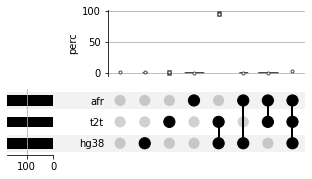

In [31]:
upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
# upset.add_catplot(value='perc', kind='violin', palette=c_dict)
upset.add_catplot(value='perc', kind='violin', color='blue', log_scale=True)
upset.plot()


In [32]:
sns.__version__

'0.12.2'